In [1]:
from Dataset_Loader import load_leafs_dataset
from Training import train_cnn
from Model_Evaluation import evaluate_model_with_outputs

from torch import nn, optim, manual_seed, flatten
from Util import apply_conv, apply_pool
import matplotlib.pyplot as plt
from time import time

d:\Downloads\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 20
test_split_size = 0.2

images_train, images_test, labels_train, labels_test = load_leafs_dataset(
    test_split_size,
    batch_size 
)

Reading CSV: 0.171 seconds
Encoding Labels: 0.042 seconds
Resizing Images: 11.548 seconds
Splitting Data: 1.402 seconds
Converting To Tensor: 23.439 seconds
Dividing To Batches: 0.307 seconds


In [3]:
input_images = images_train[:]
output_labels = labels_train[:]

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        width = 1633
        height = 1089
        self.pool1, width, height = apply_pool(width, height, kernel_size=2, stride=2)
        self.pool2, width, height = apply_pool(width, height, kernel_size=2, stride=2)
        self.pool3, width, height = apply_pool(width, height, kernel_size=2, stride=2)
    
        self.conv1, width, height = apply_conv(width, height, 1, 6, kernel_size=3, stride=1, padding=0)
        self.pool4, width, height = apply_pool(width, height, kernel_size=2, stride=2)

        self.conv2, width, height = apply_conv(width, height, 6, 16, kernel_size=3, stride=1, padding=0)
        self.pool5, width, height = apply_pool(width, height, kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16*width*height, 1000)
        self.fc2 = nn.Linear(1000, 99)

    def forward(self, x):
        x = self.pool1(x)
        x = self.pool2(x)
        x = self.pool3(x)

        x = nn.functional.relu(self.conv1(x))
        x = self.pool4(x)

        x = nn.functional.relu(self.conv2(x))
        x = self.pool5(x)

        x = flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.log_softmax(self.fc2(x), dim=1)
        return x

# Optimizer Analysis

Analysing SGD Optimizer...
Epoch: 0 / loss: 3.6664681434631348
Epoch: 1 / loss: 1.2815372943878174
Epoch: 2 / loss: 0.27160948514938354
Epoch: 3 / loss: 0.10486302524805069
Epoch: 4 / loss: 0.05233458802103996
Epoch: 5 / loss: 0.03436682000756264
Epoch: 6 / loss: 0.026307037100195885
Epoch: 7 / loss: 0.021401431411504745
Epoch: 8 / loss: 0.017984692007303238
Epoch: 9 / loss: 0.015516375191509724
Finished in 81.45 seconds
Training Accuracy: 70.83%
Testing Accuracy: 34.85%

Analysing Adagrad Optimizer...
Epoch: 0 / loss: 35.70494842529297
Epoch: 1 / loss: 10.172783851623535
Epoch: 2 / loss: 2.8577332496643066
Epoch: 3 / loss: 1.6602681875228882
Epoch: 4 / loss: 0.8466894030570984
Epoch: 5 / loss: 0.3829767405986786
Epoch: 6 / loss: 0.031240712851285934
Epoch: 7 / loss: 0.007942026481032372
Epoch: 8 / loss: 0.006609853357076645
Epoch: 9 / loss: 0.00571339949965477
Finished in 99.148 seconds
Training Accuracy: 69.57%
Testing Accuracy: 36.87%

Analysing RMSprop Optimizer...
Epoch: 0 / loss:

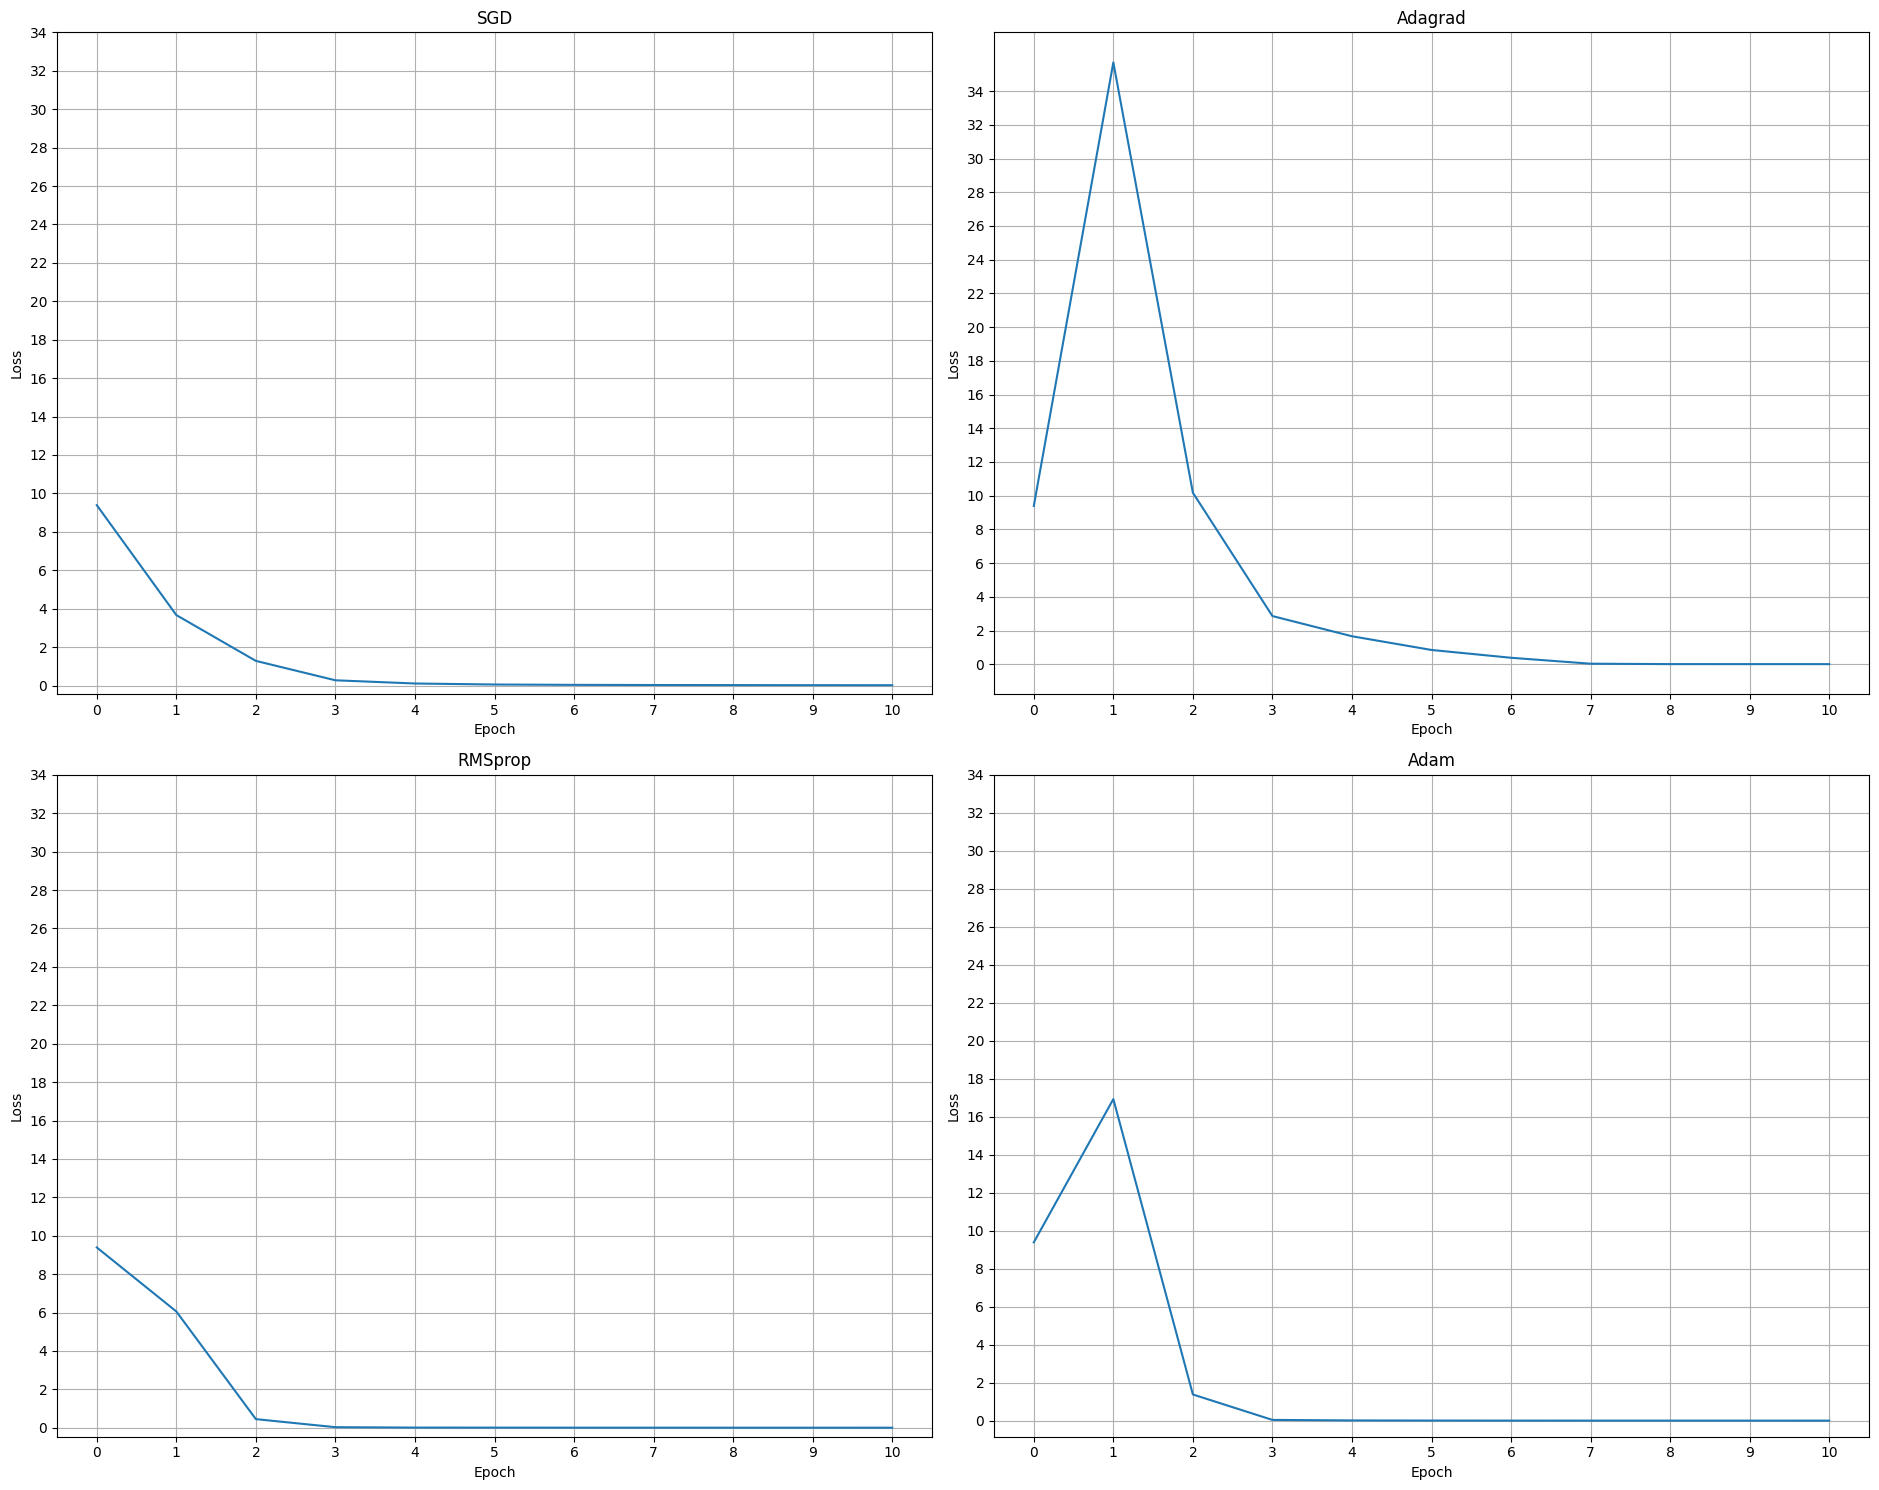

In [7]:
optimizers = [
    optim.SGD, optim.Adagrad, optim.RMSprop, optim.Adam
]
optimizer_names = [
    'SGD', 'Adagrad', 'RMSprop', 'Adam'
]
train_accuracies = []
test_accuracies = []
fig = plt.figure(figsize=(19, 15))

for i in range(len(optimizers)):
    print(f'Analysing {optimizer_names[i]} Optimizer...')
    manual_seed(1)
    model = CNN()
    optimizer = optimizers[i](model.parameters(), 0.001)
    epochs = 10
    time1 = time()
    trained_model, train_losses = train_cnn(
        model=model,
        input_tensor=input_images,
        output_tensor=output_labels,
        epochs=epochs,
        batch_size=batch_size,
        lossFunction=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        print_loss=True
    )
    time2 = time()
    print(f'Finished in {round(time2 - time1, 3)} seconds')

    train_accuracy = evaluate_model_with_outputs(model, images_train, labels_train, batch_size, 0)
    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    test_accuracy = evaluate_model_with_outputs(model, images_test, labels_test, batch_size, 1)
    print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")
    print()

    first_loss = train_losses[0][0]
    train_losses = [first_loss] + list(map(lambda x: x[-1], train_losses))

    rng_x = range(epochs+1)
    rng_y = range(0, 35, 2)

    ax = fig.add_subplot(221 + i)
    ax.set_title(optimizer_names[i])
    plt.tight_layout()
    plt.plot(rng_x, train_losses)
    plt.xlabel('Epoch')
    plt.xticks(rng_x, rng_x)
    plt.ylabel('Loss')
    plt.yticks(rng_y, rng_y)
    plt.grid()
    
plt.savefig("loss graph.jpg")
plt.show()